In [1]:
!pip install transformers torch accelerate
!pip install tensorflow_text
!pip install transformers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalle

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, BertTokenizer, TFBertModel, AutoModelForMultipleChoice, TFAutoModelForMultipleChoice, BertForMultipleChoice
from sklearn.preprocessing import LabelEncoder

import warnings
#warnings.simplefilter("ignore") # Ignore warnings
warnings.filterwarnings("ignore")
import keras
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Bidirectional, Embedding, Conv1D, MaxPooling1D, Dropout, Flatten, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint

import random
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
import joblib

### Load Data train.csv

In [3]:
df = pd.read_csv('/content/train.csv', index_col='id')
df.head()

,prompt,A,B,C,D,E,answer
id,,,,,,,
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D
1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A
3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C
4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D


In [4]:
df.shape

(200, 7)

### Pre-trained BERT model

In [5]:
model = AutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Tokenize data


In [6]:
inputs = df.apply(lambda row : " ".join([str(row["prompt"]), str(row["A"]), str(row["B"]), str(row["C"]), str(row["D"]), str(row["E"])]), axis=1).values.tolist() # better results than prompt only
train_encodings = tokenizer(inputs, truncation = True, padding = 'max_length', max_length = 512, return_tensors="pt")

### BERT embeddings

In [7]:
with torch.no_grad():
    train_outputs = model(**train_encodings)
    train_embeddings = train_outputs.last_hidden_state

### Encode labels

In [8]:
encoder = LabelEncoder()
label =  df['answer']
encoded_label = encoder.fit_transform(label)

### Chia dữ liệu thành tập huấn luyện và tập kiểm tra

In [9]:
embeddings = train_embeddings.numpy()
X = embeddings.mean(axis=1)
y= encoded_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (160, 768) (160,)
Kích thước tập kiểm tra: (40, 768) (40,)


### Xây dựng và compile, summary mô hình LSTM, GRU


In [10]:
# Model definition
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Reshape((1, -1), input_shape=(768,)),  # Reshape to add a time dimension
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 768)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                213248    
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 213573 (834.27 KB)
Trainable params: 213573 (834.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Model definition
model_gru = tf.keras.Sequential([
    tf.keras.layers.Reshape((1, -1), input_shape=(768,)),  # Reshape to add a time dimension
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model
model_gru.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 1, 768)            0         
                                                                 
 gru (GRU)                   (None, 64)                160128    
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 160453 (626.77 KB)
Trainable params: 160453 (626.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### huấn luyện mô hình LSTM, GRU

In [12]:
# LSTM
checkpoint_path_lstm = "model_checkpoint.h5"
checkpoint_callback_lstm = ModelCheckpoint(filepath=checkpoint_path_lstm, save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)

history_lstm = model_lstm.fit(X_train, y_train, epochs=100, batch_size=50, callbacks=[checkpoint_callback_lstm])

Epoch 1/100
1/4 [======>.......................] - ETA: 7s - loss: 1.6169 - accuracy: 0.1600

4/4 [==============================] - 2s 13ms/step - loss: 1.6115 - accuracy: 0.2125
Epoch 2/100
1/4 [======>.......................] - ETA: 0s - loss: 1.6210 - accuracy: 0.1800

4/4 [==============================] - 0s 9ms/step - loss: 1.6054 - accuracy: 0.2250
Epoch 3/100
1/4 [======>.......................] - ETA: 0s - loss: 1.6009 - accuracy: 0.2000

4/4 [==============================] - 0s 9ms/step - loss: 1.6013 - accuracy: 0.2188
Epoch 4/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5991 - accuracy: 0.2400

4/4 [==============================] - 0s 11ms/step - loss: 1.5975 - accuracy: 0.2375
Epoch 5/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5878 - accuracy: 0.2600

4/4 [==============================] - 0s 9ms/step - loss: 1.5938 - accuracy: 0.2438
Epoch 6/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5740 - accuracy: 0.3200

4/4 [==============================] - 0s 11ms/step - loss: 1.5911 - accuracy: 0.2500
Epoch 7/100
1/4 [======>.......................] - ETA: 0s - loss: 1.6104 - accuracy: 0.1600

4/4 [==============================] - 0s 11ms/step - loss: 1.5880 - accuracy: 0.2688
Epoch 8/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5837 - accuracy: 0.2600

4/4 [==============================] - 0s 11ms/step - loss: 1.5847 - accuracy: 0.2688
Epoch 9/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5769 - accuracy: 0.2800

4/4 [==============================] - 0s 9ms/step - loss: 1.5820 - accuracy: 0.2562
Epoch 10/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5658 - accuracy: 0.3000

4/4 [==============================] - 0s 12ms/step - loss: 1.5796 - accuracy: 0.3125
Epoch 11/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5691 - accuracy: 0.3200

4/4 [==============================] - 0s 9ms/step - loss: 1.5773 - accuracy: 0.3125
Epoch 12/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5699 - accuracy: 0.3200

4/4 [==============================] - 0s 9ms/step - loss: 1.5746 - accuracy: 0.3187
Epoch 13/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5787 - accuracy: 0.4000

4/4 [==============================] - 0s 9ms/step - loss: 1.5716 - accuracy: 0.3250
Epoch 14/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5957 - accuracy: 0.2400

4/4 [==============================] - 0s 12ms/step - loss: 1.5685 - accuracy: 0.3250
Epoch 15/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5501 - accuracy: 0.4200

4/4 [==============================] - 0s 10ms/step - loss: 1.5655 - accuracy: 0.3500
Epoch 16/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5589 - accuracy: 0.3400

4/4 [==============================] - 0s 10ms/step - loss: 1.5623 - accuracy: 0.3688
Epoch 17/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5716 - accuracy: 0.2600

4/4 [==============================] - 0s 9ms/step - loss: 1.5595 - accuracy: 0.3688
Epoch 18/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5574 - accuracy: 0.4400

4/4 [==============================] - 0s 8ms/step - loss: 1.5563 - accuracy: 0.4000
Epoch 19/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5711 - accuracy: 0.3800

4/4 [==============================] - 0s 8ms/step - loss: 1.5539 - accuracy: 0.4250
Epoch 20/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5435 - accuracy: 0.5200

4/4 [==============================] - 0s 8ms/step - loss: 1.5504 - accuracy: 0.4500
Epoch 21/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5596 - accuracy: 0.4800

4/4 [==============================] - 0s 9ms/step - loss: 1.5475 - accuracy: 0.4437
Epoch 22/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5526 - accuracy: 0.4800

4/4 [==============================] - 0s 9ms/step - loss: 1.5442 - accuracy: 0.4375
Epoch 23/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5351 - accuracy: 0.5200

4/4 [==============================] - 0s 11ms/step - loss: 1.5409 - accuracy: 0.4563
Epoch 24/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5396 - accuracy: 0.5400

4/4 [==============================] - 0s 9ms/step - loss: 1.5372 - accuracy: 0.4875
Epoch 25/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5258 - accuracy: 0.5200

4/4 [==============================] - 0s 10ms/step - loss: 1.5341 - accuracy: 0.4688
Epoch 26/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5332 - accuracy: 0.4800

4/4 [==============================] - 0s 10ms/step - loss: 1.5306 - accuracy: 0.4750
Epoch 27/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5121 - accuracy: 0.6000

4/4 [==============================] - 0s 9ms/step - loss: 1.5272 - accuracy: 0.4750
Epoch 28/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5269 - accuracy: 0.4000

4/4 [==============================] - 0s 10ms/step - loss: 1.5236 - accuracy: 0.4688
Epoch 29/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5465 - accuracy: 0.3600

4/4 [==============================] - 0s 11ms/step - loss: 1.5204 - accuracy: 0.4437
Epoch 30/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5301 - accuracy: 0.3600

4/4 [==============================] - 0s 10ms/step - loss: 1.5169 - accuracy: 0.4313
Epoch 31/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5157 - accuracy: 0.4800

4/4 [==============================] - 0s 9ms/step - loss: 1.5132 - accuracy: 0.4500
Epoch 32/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5010 - accuracy: 0.4800

4/4 [==============================] - 0s 13ms/step - loss: 1.5090 - accuracy: 0.4688
Epoch 33/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5091 - accuracy: 0.5000

4/4 [==============================] - 0s 9ms/step - loss: 1.5050 - accuracy: 0.4812
Epoch 34/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5165 - accuracy: 0.4800

4/4 [==============================] - 0s 11ms/step - loss: 1.5002 - accuracy: 0.5000
Epoch 35/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4934 - accuracy: 0.5200

4/4 [==============================] - 0s 9ms/step - loss: 1.4958 - accuracy: 0.5375
Epoch 36/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5016 - accuracy: 0.4600

4/4 [==============================] - 0s 10ms/step - loss: 1.4912 - accuracy: 0.5125
Epoch 37/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4793 - accuracy: 0.5400

4/4 [==============================] - 0s 9ms/step - loss: 1.4882 - accuracy: 0.5250
Epoch 38/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4670 - accuracy: 0.5600

4/4 [==============================] - 0s 9ms/step - loss: 1.4831 - accuracy: 0.5125
Epoch 39/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4661 - accuracy: 0.5200

4/4 [==============================] - 0s 9ms/step - loss: 1.4792 - accuracy: 0.4938
Epoch 40/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4687 - accuracy: 0.5200

4/4 [==============================] - 0s 10ms/step - loss: 1.4749 - accuracy: 0.4938
Epoch 41/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4739 - accuracy: 0.4800

4/4 [==============================] - 0s 10ms/step - loss: 1.4700 - accuracy: 0.4938
Epoch 42/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4854 - accuracy: 0.5000

4/4 [==============================] - 0s 9ms/step - loss: 1.4649 - accuracy: 0.5188
Epoch 43/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4853 - accuracy: 0.4400

4/4 [==============================] - 0s 9ms/step - loss: 1.4591 - accuracy: 0.5125
Epoch 44/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4308 - accuracy: 0.5600

4/4 [==============================] - 0s 10ms/step - loss: 1.4541 - accuracy: 0.5250
Epoch 45/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4604 - accuracy: 0.4200

4/4 [==============================] - 0s 9ms/step - loss: 1.4497 - accuracy: 0.5375
Epoch 46/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4457 - accuracy: 0.6000

4/4 [==============================] - 0s 9ms/step - loss: 1.4440 - accuracy: 0.5688
Epoch 47/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4244 - accuracy: 0.5800

4/4 [==============================] - 0s 8ms/step - loss: 1.4393 - accuracy: 0.5437
Epoch 48/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4755 - accuracy: 0.4200

4/4 [==============================] - 0s 9ms/step - loss: 1.4348 - accuracy: 0.5500
Epoch 49/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4525 - accuracy: 0.4400

4/4 [==============================] - 0s 10ms/step - loss: 1.4295 - accuracy: 0.5500
Epoch 50/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3879 - accuracy: 0.6800

4/4 [==============================] - 0s 9ms/step - loss: 1.4239 - accuracy: 0.5750
Epoch 51/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4697 - accuracy: 0.5000

4/4 [==============================] - 0s 9ms/step - loss: 1.4185 - accuracy: 0.6000
Epoch 52/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4071 - accuracy: 0.6800

4/4 [==============================] - 0s 8ms/step - loss: 1.4135 - accuracy: 0.6062
Epoch 53/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4222 - accuracy: 0.5200

4/4 [==============================] - 0s 9ms/step - loss: 1.4078 - accuracy: 0.5875
Epoch 54/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3967 - accuracy: 0.6800

4/4 [==============================] - 0s 11ms/step - loss: 1.4024 - accuracy: 0.6000
Epoch 55/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4196 - accuracy: 0.5000

4/4 [==============================] - 0s 10ms/step - loss: 1.3981 - accuracy: 0.5875
Epoch 56/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3727 - accuracy: 0.6400

4/4 [==============================] - 0s 9ms/step - loss: 1.3925 - accuracy: 0.5938
Epoch 57/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3919 - accuracy: 0.6000

4/4 [==============================] - 0s 9ms/step - loss: 1.3874 - accuracy: 0.5875
Epoch 58/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3924 - accuracy: 0.5800

4/4 [==============================] - 0s 9ms/step - loss: 1.3820 - accuracy: 0.5813
Epoch 59/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3564 - accuracy: 0.6000

4/4 [==============================] - 0s 9ms/step - loss: 1.3766 - accuracy: 0.5562
Epoch 60/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3732 - accuracy: 0.6000

4/4 [==============================] - 0s 9ms/step - loss: 1.3705 - accuracy: 0.5625
Epoch 61/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3662 - accuracy: 0.5200

4/4 [==============================] - 0s 9ms/step - loss: 1.3645 - accuracy: 0.6062
Epoch 62/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3614 - accuracy: 0.6200

4/4 [==============================] - 0s 9ms/step - loss: 1.3582 - accuracy: 0.6062
Epoch 63/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3413 - accuracy: 0.6000

4/4 [==============================] - 0s 9ms/step - loss: 1.3520 - accuracy: 0.6000
Epoch 64/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3956 - accuracy: 0.4800

4/4 [==============================] - 0s 9ms/step - loss: 1.3478 - accuracy: 0.5938
Epoch 65/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3390 - accuracy: 0.6000

4/4 [==============================] - 0s 10ms/step - loss: 1.3426 - accuracy: 0.5938
Epoch 66/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3917 - accuracy: 0.5200

4/4 [==============================] - 0s 10ms/step - loss: 1.3370 - accuracy: 0.5938
Epoch 67/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2769 - accuracy: 0.7000

4/4 [==============================] - 0s 9ms/step - loss: 1.3310 - accuracy: 0.6000
Epoch 68/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3155 - accuracy: 0.5600

4/4 [==============================] - 0s 11ms/step - loss: 1.3247 - accuracy: 0.6062
Epoch 69/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3023 - accuracy: 0.7000

4/4 [==============================] - 0s 9ms/step - loss: 1.3193 - accuracy: 0.6125
Epoch 70/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2949 - accuracy: 0.7000

4/4 [==============================] - 0s 12ms/step - loss: 1.3134 - accuracy: 0.6375
Epoch 71/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3249 - accuracy: 0.5800

4/4 [==============================] - 0s 9ms/step - loss: 1.3080 - accuracy: 0.6250
Epoch 72/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2899 - accuracy: 0.6400

4/4 [==============================] - 0s 9ms/step - loss: 1.3055 - accuracy: 0.6313
Epoch 73/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3065 - accuracy: 0.6000

4/4 [==============================] - 0s 9ms/step - loss: 1.3002 - accuracy: 0.6250
Epoch 74/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2829 - accuracy: 0.5600

4/4 [==============================] - 0s 9ms/step - loss: 1.2948 - accuracy: 0.6250
Epoch 75/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3277 - accuracy: 0.5600

4/4 [==============================] - 0s 9ms/step - loss: 1.2898 - accuracy: 0.6313
Epoch 76/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2724 - accuracy: 0.6400

4/4 [==============================] - 0s 9ms/step - loss: 1.2843 - accuracy: 0.6313
Epoch 77/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2554 - accuracy: 0.6800

4/4 [==============================] - 0s 12ms/step - loss: 1.2785 - accuracy: 0.6375
Epoch 78/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2834 - accuracy: 0.6000

4/4 [==============================] - 0s 9ms/step - loss: 1.2726 - accuracy: 0.6438
Epoch 79/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2361 - accuracy: 0.7000

4/4 [==============================] - 0s 10ms/step - loss: 1.2670 - accuracy: 0.6500
Epoch 80/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2768 - accuracy: 0.6600

4/4 [==============================] - 0s 9ms/step - loss: 1.2602 - accuracy: 0.6500
Epoch 81/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2185 - accuracy: 0.7000

4/4 [==============================] - 0s 10ms/step - loss: 1.2550 - accuracy: 0.6500
Epoch 82/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2220 - accuracy: 0.6600

4/4 [==============================] - 0s 11ms/step - loss: 1.2490 - accuracy: 0.6375
Epoch 83/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2706 - accuracy: 0.5600

4/4 [==============================] - 0s 10ms/step - loss: 1.2440 - accuracy: 0.6375
Epoch 84/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2854 - accuracy: 0.6000

4/4 [==============================] - 0s 9ms/step - loss: 1.2385 - accuracy: 0.6313
Epoch 85/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2670 - accuracy: 0.6000

4/4 [==============================] - 0s 9ms/step - loss: 1.2327 - accuracy: 0.6250
Epoch 86/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2872 - accuracy: 0.6000

4/4 [==============================] - 0s 10ms/step - loss: 1.2270 - accuracy: 0.6375
Epoch 87/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2254 - accuracy: 0.6200

4/4 [==============================] - 0s 8ms/step - loss: 1.2214 - accuracy: 0.6562
Epoch 88/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2217 - accuracy: 0.6000

4/4 [==============================] - 0s 9ms/step - loss: 1.2164 - accuracy: 0.6438
Epoch 89/100
1/4 [======>.......................] - ETA: 0s - loss: 1.1988 - accuracy: 0.7000

4/4 [==============================] - 0s 11ms/step - loss: 1.2122 - accuracy: 0.6812
Epoch 90/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2029 - accuracy: 0.7000

4/4 [==============================] - 0s 10ms/step - loss: 1.2058 - accuracy: 0.6750
Epoch 91/100
1/4 [======>.......................] - ETA: 0s - loss: 1.1688 - accuracy: 0.6600

4/4 [==============================] - 0s 9ms/step - loss: 1.2006 - accuracy: 0.6687
Epoch 92/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2143 - accuracy: 0.6600

4/4 [==============================] - 0s 9ms/step - loss: 1.1941 - accuracy: 0.6687
Epoch 93/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2260 - accuracy: 0.6000

4/4 [==============================] - 0s 9ms/step - loss: 1.1888 - accuracy: 0.6625
Epoch 94/100
1/4 [======>.......................] - ETA: 0s - loss: 1.1816 - accuracy: 0.6000

4/4 [==============================] - 0s 11ms/step - loss: 1.1862 - accuracy: 0.6562
Epoch 95/100
1/4 [======>.......................] - ETA: 0s - loss: 1.1572 - accuracy: 0.6200

4/4 [==============================] - 0s 9ms/step - loss: 1.1827 - accuracy: 0.6375
Epoch 96/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2103 - accuracy: 0.6400

4/4 [==============================] - 0s 9ms/step - loss: 1.1795 - accuracy: 0.6375
Epoch 97/100
1/4 [======>.......................] - ETA: 0s - loss: 1.1727 - accuracy: 0.6200

4/4 [==============================] - 0s 9ms/step - loss: 1.1722 - accuracy: 0.6438
Epoch 98/100
1/4 [======>.......................] - ETA: 0s - loss: 1.1686 - accuracy: 0.6800

4/4 [==============================] - 0s 11ms/step - loss: 1.1655 - accuracy: 0.6438
Epoch 99/100
1/4 [======>.......................] - ETA: 0s - loss: 1.1546 - accuracy: 0.6000

4/4 [==============================] - 0s 12ms/step - loss: 1.1608 - accuracy: 0.6500
Epoch 100/100
1/4 [======>.......................] - ETA: 0s - loss: 1.1562 - accuracy: 0.6400

4/4 [==============================] - 0s 11ms/step - loss: 1.1557 - accuracy: 0.6625


In [13]:
#GRU
checkpoint_path_gru = "model_checkpoint.h5"
checkpoint_callback_gru = ModelCheckpoint(filepath=checkpoint_path_gru, save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)

history_gru = model_gru.fit(X_train, y_train, epochs=100, batch_size=50, callbacks=[checkpoint_callback_gru])

Epoch 1/100
1/4 [======>.......................] - ETA: 6s - loss: 1.6751 - accuracy: 0.2000

4/4 [==============================] - 2s 18ms/step - loss: 1.6558 - accuracy: 0.2000
Epoch 2/100
1/4 [======>.......................] - ETA: 0s - loss: 1.6199 - accuracy: 0.2400

4/4 [==============================] - 0s 12ms/step - loss: 1.6298 - accuracy: 0.2062
Epoch 3/100
1/4 [======>.......................] - ETA: 0s - loss: 1.6331 - accuracy: 0.3000

4/4 [==============================] - 0s 15ms/step - loss: 1.6159 - accuracy: 0.2125
Epoch 4/100
1/4 [======>.......................] - ETA: 0s - loss: 1.6081 - accuracy: 0.2200

4/4 [==============================] - 0s 13ms/step - loss: 1.6051 - accuracy: 0.2250
Epoch 5/100
1/4 [======>.......................] - ETA: 0s - loss: 1.6310 - accuracy: 0.1800

4/4 [==============================] - 0s 12ms/step - loss: 1.5981 - accuracy: 0.2125
Epoch 6/100
1/4 [======>.......................] - ETA: 0s - loss: 1.6567 - accuracy: 0.1200

4/4 [==============================] - 0s 13ms/step - loss: 1.5911 - accuracy: 0.2188
Epoch 7/100
1/4 [======>.......................] - ETA: 0s - loss: 1.6263 - accuracy: 0.1600

4/4 [==============================] - 0s 14ms/step - loss: 1.5853 - accuracy: 0.2562
Epoch 8/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5508 - accuracy: 0.3000

4/4 [==============================] - 0s 14ms/step - loss: 1.5806 - accuracy: 0.2812
Epoch 9/100
1/4 [======>.......................] - ETA: 0s - loss: 1.6054 - accuracy: 0.2600

4/4 [==============================] - 0s 13ms/step - loss: 1.5759 - accuracy: 0.2812
Epoch 10/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5662 - accuracy: 0.2800

4/4 [==============================] - 0s 14ms/step - loss: 1.5715 - accuracy: 0.2875
Epoch 11/100
1/4 [======>.......................] - ETA: 0s - loss: 1.6002 - accuracy: 0.3000

4/4 [==============================] - 0s 12ms/step - loss: 1.5684 - accuracy: 0.3125
Epoch 12/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5817 - accuracy: 0.2000

4/4 [==============================] - 0s 10ms/step - loss: 1.5630 - accuracy: 0.3000
Epoch 13/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5288 - accuracy: 0.4000

4/4 [==============================] - 0s 12ms/step - loss: 1.5583 - accuracy: 0.3063
Epoch 14/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5631 - accuracy: 0.3400

4/4 [==============================] - 0s 13ms/step - loss: 1.5543 - accuracy: 0.3375
Epoch 15/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5542 - accuracy: 0.3600

4/4 [==============================] - 0s 15ms/step - loss: 1.5495 - accuracy: 0.3375
Epoch 16/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5153 - accuracy: 0.4600

4/4 [==============================] - 0s 12ms/step - loss: 1.5449 - accuracy: 0.3375
Epoch 17/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5218 - accuracy: 0.3600

4/4 [==============================] - 0s 13ms/step - loss: 1.5408 - accuracy: 0.3438
Epoch 18/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5234 - accuracy: 0.4000

4/4 [==============================] - 0s 13ms/step - loss: 1.5370 - accuracy: 0.3500
Epoch 19/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5488 - accuracy: 0.3800

4/4 [==============================] - 0s 15ms/step - loss: 1.5332 - accuracy: 0.3812
Epoch 20/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5053 - accuracy: 0.5400

4/4 [==============================] - 0s 13ms/step - loss: 1.5287 - accuracy: 0.4125
Epoch 21/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5203 - accuracy: 0.4600

4/4 [==============================] - 0s 14ms/step - loss: 1.5250 - accuracy: 0.4375
Epoch 22/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5287 - accuracy: 0.4400

4/4 [==============================] - 0s 13ms/step - loss: 1.5210 - accuracy: 0.4313
Epoch 23/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5182 - accuracy: 0.4400

4/4 [==============================] - 0s 12ms/step - loss: 1.5164 - accuracy: 0.4375
Epoch 24/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5119 - accuracy: 0.4400

4/4 [==============================] - 0s 13ms/step - loss: 1.5130 - accuracy: 0.4625
Epoch 25/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5103 - accuracy: 0.5000

4/4 [==============================] - 0s 12ms/step - loss: 1.5090 - accuracy: 0.4688
Epoch 26/100
1/4 [======>.......................] - ETA: 0s - loss: 1.5099 - accuracy: 0.5200

4/4 [==============================] - 0s 12ms/step - loss: 1.5048 - accuracy: 0.4750
Epoch 27/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4851 - accuracy: 0.5000

4/4 [==============================] - 0s 13ms/step - loss: 1.5010 - accuracy: 0.4688
Epoch 28/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4770 - accuracy: 0.5200

4/4 [==============================] - 0s 12ms/step - loss: 1.4959 - accuracy: 0.4688
Epoch 29/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4587 - accuracy: 0.4600

4/4 [==============================] - 0s 13ms/step - loss: 1.4917 - accuracy: 0.4688
Epoch 30/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4685 - accuracy: 0.4400

4/4 [==============================] - 0s 12ms/step - loss: 1.4881 - accuracy: 0.4563
Epoch 31/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4832 - accuracy: 0.4800

4/4 [==============================] - 0s 13ms/step - loss: 1.4834 - accuracy: 0.4875
Epoch 32/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4734 - accuracy: 0.5200

4/4 [==============================] - 0s 17ms/step - loss: 1.4789 - accuracy: 0.5000
Epoch 33/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4882 - accuracy: 0.4600

4/4 [==============================] - 0s 11ms/step - loss: 1.4744 - accuracy: 0.5000
Epoch 34/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4876 - accuracy: 0.4200

4/4 [==============================] - 0s 12ms/step - loss: 1.4707 - accuracy: 0.4938
Epoch 35/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4779 - accuracy: 0.5000

4/4 [==============================] - 0s 13ms/step - loss: 1.4660 - accuracy: 0.4750
Epoch 36/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4548 - accuracy: 0.5000

4/4 [==============================] - 0s 12ms/step - loss: 1.4618 - accuracy: 0.4938
Epoch 37/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4461 - accuracy: 0.6000

4/4 [==============================] - 0s 13ms/step - loss: 1.4579 - accuracy: 0.5125
Epoch 38/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4548 - accuracy: 0.5200

4/4 [==============================] - 0s 12ms/step - loss: 1.4536 - accuracy: 0.5063
Epoch 39/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4177 - accuracy: 0.5800

4/4 [==============================] - 0s 12ms/step - loss: 1.4488 - accuracy: 0.5312
Epoch 40/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4636 - accuracy: 0.5600

4/4 [==============================] - 0s 12ms/step - loss: 1.4438 - accuracy: 0.5750
Epoch 41/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4259 - accuracy: 0.6600

4/4 [==============================] - 0s 12ms/step - loss: 1.4394 - accuracy: 0.5625
Epoch 42/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4792 - accuracy: 0.4200

4/4 [==============================] - 0s 13ms/step - loss: 1.4348 - accuracy: 0.5688
Epoch 43/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4244 - accuracy: 0.6000

4/4 [==============================] - 0s 12ms/step - loss: 1.4299 - accuracy: 0.5625
Epoch 44/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4217 - accuracy: 0.4800

4/4 [==============================] - 0s 12ms/step - loss: 1.4259 - accuracy: 0.5312
Epoch 45/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4531 - accuracy: 0.4400

4/4 [==============================] - 0s 12ms/step - loss: 1.4217 - accuracy: 0.5125
Epoch 46/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4189 - accuracy: 0.5600

4/4 [==============================] - 0s 13ms/step - loss: 1.4166 - accuracy: 0.5250
Epoch 47/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4077 - accuracy: 0.5600

4/4 [==============================] - 0s 12ms/step - loss: 1.4121 - accuracy: 0.5500
Epoch 48/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4229 - accuracy: 0.5200

4/4 [==============================] - 0s 14ms/step - loss: 1.4076 - accuracy: 0.5562
Epoch 49/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3999 - accuracy: 0.6400

4/4 [==============================] - 0s 14ms/step - loss: 1.4028 - accuracy: 0.5688
Epoch 50/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3931 - accuracy: 0.7000

4/4 [==============================] - 0s 13ms/step - loss: 1.3986 - accuracy: 0.5688
Epoch 51/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3662 - accuracy: 0.6200

4/4 [==============================] - 0s 12ms/step - loss: 1.3948 - accuracy: 0.5500
Epoch 52/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4191 - accuracy: 0.5200

4/4 [==============================] - 0s 12ms/step - loss: 1.3904 - accuracy: 0.5562
Epoch 53/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3530 - accuracy: 0.5600

4/4 [==============================] - 0s 14ms/step - loss: 1.3856 - accuracy: 0.5375
Epoch 54/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3704 - accuracy: 0.5600

4/4 [==============================] - 0s 13ms/step - loss: 1.3812 - accuracy: 0.5437
Epoch 55/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3347 - accuracy: 0.6800

4/4 [==============================] - 0s 14ms/step - loss: 1.3764 - accuracy: 0.5750
Epoch 56/100
1/4 [======>.......................] - ETA: 0s - loss: 1.4051 - accuracy: 0.5400

4/4 [==============================] - 0s 13ms/step - loss: 1.3713 - accuracy: 0.5938
Epoch 57/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3618 - accuracy: 0.5400

4/4 [==============================] - 0s 12ms/step - loss: 1.3664 - accuracy: 0.5938
Epoch 58/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3458 - accuracy: 0.5600

4/4 [==============================] - 0s 12ms/step - loss: 1.3617 - accuracy: 0.5938
Epoch 59/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3830 - accuracy: 0.6000

4/4 [==============================] - 0s 11ms/step - loss: 1.3576 - accuracy: 0.5875
Epoch 60/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3578 - accuracy: 0.6200

4/4 [==============================] - 0s 13ms/step - loss: 1.3533 - accuracy: 0.5813
Epoch 61/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3527 - accuracy: 0.5800

4/4 [==============================] - 0s 11ms/step - loss: 1.3486 - accuracy: 0.5875
Epoch 62/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3103 - accuracy: 0.6200

4/4 [==============================] - 0s 12ms/step - loss: 1.3442 - accuracy: 0.5938
Epoch 63/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3784 - accuracy: 0.6200

4/4 [==============================] - 0s 11ms/step - loss: 1.3408 - accuracy: 0.5875
Epoch 64/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3713 - accuracy: 0.5200

4/4 [==============================] - 0s 11ms/step - loss: 1.3356 - accuracy: 0.6062
Epoch 65/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3690 - accuracy: 0.5600

4/4 [==============================] - 0s 11ms/step - loss: 1.3319 - accuracy: 0.6000
Epoch 66/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2568 - accuracy: 0.7400

4/4 [==============================] - 0s 14ms/step - loss: 1.3264 - accuracy: 0.6062
Epoch 67/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3653 - accuracy: 0.5400

4/4 [==============================] - 0s 13ms/step - loss: 1.3219 - accuracy: 0.6125
Epoch 68/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2961 - accuracy: 0.6600

4/4 [==============================] - 0s 14ms/step - loss: 1.3166 - accuracy: 0.6125
Epoch 69/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2911 - accuracy: 0.7200

4/4 [==============================] - 0s 15ms/step - loss: 1.3119 - accuracy: 0.6125
Epoch 70/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3284 - accuracy: 0.6400

4/4 [==============================] - 0s 13ms/step - loss: 1.3088 - accuracy: 0.6125
Epoch 71/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3014 - accuracy: 0.6000

4/4 [==============================] - 0s 13ms/step - loss: 1.3045 - accuracy: 0.6187
Epoch 72/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2757 - accuracy: 0.6000

4/4 [==============================] - 0s 11ms/step - loss: 1.2990 - accuracy: 0.6125
Epoch 73/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3258 - accuracy: 0.5400

4/4 [==============================] - 0s 12ms/step - loss: 1.2944 - accuracy: 0.6125
Epoch 74/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2813 - accuracy: 0.6600

4/4 [==============================] - 0s 12ms/step - loss: 1.2899 - accuracy: 0.6313
Epoch 75/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3248 - accuracy: 0.6000

4/4 [==============================] - 0s 14ms/step - loss: 1.2857 - accuracy: 0.6313
Epoch 76/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2771 - accuracy: 0.6600

4/4 [==============================] - 0s 12ms/step - loss: 1.2826 - accuracy: 0.6313
Epoch 77/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3081 - accuracy: 0.5200

4/4 [==============================] - 0s 13ms/step - loss: 1.2786 - accuracy: 0.6375
Epoch 78/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2177 - accuracy: 0.7000

4/4 [==============================] - 0s 11ms/step - loss: 1.2752 - accuracy: 0.6438
Epoch 79/100
1/4 [======>.......................] - ETA: 0s - loss: 1.3416 - accuracy: 0.6000

4/4 [==============================] - 0s 14ms/step - loss: 1.2692 - accuracy: 0.6375
Epoch 80/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2191 - accuracy: 0.7400

4/4 [==============================] - 0s 12ms/step - loss: 1.2647 - accuracy: 0.6313
Epoch 81/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2849 - accuracy: 0.5800

4/4 [==============================] - 0s 16ms/step - loss: 1.2589 - accuracy: 0.6250
Epoch 82/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2617 - accuracy: 0.6400

4/4 [==============================] - 0s 13ms/step - loss: 1.2551 - accuracy: 0.6250
Epoch 83/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2489 - accuracy: 0.6200

4/4 [==============================] - 0s 13ms/step - loss: 1.2494 - accuracy: 0.6250
Epoch 84/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2586 - accuracy: 0.6400

4/4 [==============================] - 0s 12ms/step - loss: 1.2459 - accuracy: 0.6187
Epoch 85/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2149 - accuracy: 0.6600

4/4 [==============================] - 0s 15ms/step - loss: 1.2425 - accuracy: 0.6125
Epoch 86/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2570 - accuracy: 0.6000

4/4 [==============================] - 0s 18ms/step - loss: 1.2378 - accuracy: 0.6313
Epoch 87/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2509 - accuracy: 0.6000

4/4 [==============================] - 0s 13ms/step - loss: 1.2333 - accuracy: 0.6187
Epoch 88/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2268 - accuracy: 0.6800

4/4 [==============================] - 0s 14ms/step - loss: 1.2277 - accuracy: 0.6250
Epoch 89/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2738 - accuracy: 0.5400

4/4 [==============================] - 0s 13ms/step - loss: 1.2242 - accuracy: 0.6187
Epoch 90/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2289 - accuracy: 0.5800

4/4 [==============================] - 0s 13ms/step - loss: 1.2187 - accuracy: 0.6375
Epoch 91/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2176 - accuracy: 0.6400

4/4 [==============================] - 0s 15ms/step - loss: 1.2148 - accuracy: 0.6438
Epoch 92/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2140 - accuracy: 0.6600

4/4 [==============================] - 0s 13ms/step - loss: 1.2111 - accuracy: 0.6375
Epoch 93/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2143 - accuracy: 0.6400

4/4 [==============================] - 0s 12ms/step - loss: 1.2064 - accuracy: 0.6562
Epoch 94/100
1/4 [======>.......................] - ETA: 0s - loss: 1.1610 - accuracy: 0.7400

4/4 [==============================] - 0s 12ms/step - loss: 1.2017 - accuracy: 0.6687
Epoch 95/100
1/4 [======>.......................] - ETA: 0s - loss: 1.1921 - accuracy: 0.7200

4/4 [==============================] - 0s 12ms/step - loss: 1.1976 - accuracy: 0.6750
Epoch 96/100
1/4 [======>.......................] - ETA: 0s - loss: 1.1660 - accuracy: 0.7200

4/4 [==============================] - 0s 14ms/step - loss: 1.1933 - accuracy: 0.6812
Epoch 97/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2169 - accuracy: 0.6000

4/4 [==============================] - 0s 13ms/step - loss: 1.1885 - accuracy: 0.6750
Epoch 98/100
1/4 [======>.......................] - ETA: 0s - loss: 1.1887 - accuracy: 0.7200

4/4 [==============================] - 0s 13ms/step - loss: 1.1860 - accuracy: 0.6812
Epoch 99/100
1/4 [======>.......................] - ETA: 0s - loss: 1.2458 - accuracy: 0.6000

4/4 [==============================] - 0s 12ms/step - loss: 1.1814 - accuracy: 0.6687
Epoch 100/100
1/4 [======>.......................] - ETA: 0s - loss: 1.1375 - accuracy: 0.6600

4/4 [==============================] - 0s 14ms/step - loss: 1.1772 - accuracy: 0.6625


### Đánh giá mô hình LSTM, GRU

In [14]:
# Make predictions LSTM on the test set
y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)

# Calculate confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
print("Confusion Matrix:")
print(cm_lstm)

# Calculate accuracy score
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)

# Calculate loss
loss_lstm = model_lstm.evaluate(X_test, y_test)
print("Loss :", loss_lstm)

# Calculate F1 score
f1_lstm = f1_score(y_test, y_pred_lstm, average='weighted')  # You can use 'micro', 'macro', or 'weighted' as per your requirement

2/2 [==============================] - 0s 7ms/step
Confusion Matrix:
[[2 1 2 0 1]
 [1 4 5 1 0]
 [0 2 5 0 2]
 [1 3 2 0 0]
 [1 2 5 0 0]]
2/2 [==============================] - 1s 9ms/step - loss: 1.7836 - accuracy: 0.2750
Loss : [1.7835737466812134, 0.2750000059604645]


In [15]:
# Make predictions GRU on the test set
y_pred_gru = np.argmax(model_gru.predict(X_test), axis=1)


# Calculate confusion matrix
cm_gru = confusion_matrix(y_test, y_pred_gru)
print("Confusion Matrix:")
print(cm_gru)

# Calculate accuracy score
accuracy_gru = accuracy_score(y_test, y_pred_gru)

# Calculate loss
loss_gru = model_gru.evaluate(X_test, y_test)
print("Loss :", loss_gru)

# Calculate F1 score
f1_gru = f1_score(y_test, y_pred_gru, average='weighted')  # You can use 'micro', 'macro', or 'weighted' as per your requirement

2/2 [==============================] - 0s 6ms/step
Confusion Matrix:
[[2 1 2 0 1]
 [1 3 5 2 0]
 [2 2 3 1 1]
 [0 2 3 0 1]
 [0 3 5 0 0]]
2/2 [==============================] - 1s 8ms/step - loss: 1.8182 - accuracy: 0.2000
Loss : [1.8182414770126343, 0.20000000298023224]


In [16]:
print("LSTM")
print("Accuracy Score:", accuracy_lstm)
print("F1 Score:", f1_lstm)
print("\n")
print("GRU")
print("Accuracy Score:", accuracy_gru)
print("F1 Score:", f1_gru)

LSTM
Accuracy Score: 0.275
F1 Score: 0.2305547713156409


GRU
Accuracy Score: 0.2
F1 Score: 0.17954545454545454


### Dự đoán answer đúng và top 3 answer cao nhất của mỗi câu hỏi

In [17]:
y_pred_lstm = model_lstm.predict(X_test)

for i in range(5):
    answer_probs = y_pred_lstm[i]
    top_k_idxs = answer_probs.argsort()[-3:][::-1]
    print("Answer probs:", answer_probs)
    print("Top 3:", ['ABCDE'[k] for k in top_k_idxs])
    print('Predicted answer:', 'ABCDE'[answer_probs.argmax()])
    print('Actual answer:', label.iloc[i])

2/2 [==============================] - 0s 5ms/step
Answer probs: [0.20333968 0.2490425  0.27873668 0.20548789 0.06339318]
Top 3: ['C', 'B', 'D']
Predicted answer: C
Actual answer: D
Answer probs: [0.17922851 0.22192314 0.28215054 0.16678147 0.14991637]
Top 3: ['C', 'B', 'A']
Predicted answer: C
Actual answer: A
Answer probs: [0.14791578 0.18490647 0.27068022 0.22111146 0.17538615]
Top 3: ['C', 'D', 'B']
Predicted answer: C
Actual answer: A
Answer probs: [0.08387176 0.3451494  0.2392915  0.14988172 0.18180558]
Top 3: ['B', 'C', 'E']
Predicted answer: B
Actual answer: C
Answer probs: [0.11491778 0.20689961 0.34995025 0.24664825 0.08158398]
Top 3: ['C', 'D', 'B']
Predicted answer: C
Actual answer: D


In [18]:
y_pred_gru = model_gru.predict(X_test)

for i in range(5):
    answer_probs = y_pred_gru[i]
    top_k_idxs = answer_probs.argsort()[-3:][::-1]
    print("Answer probs:", answer_probs)
    print("Top 3:", ['ABCDE'[k] for k in top_k_idxs])
    print('Predicted answer:', 'ABCDE'[answer_probs.argmax()])
    print('Actual answer:', label.iloc[i])

2/2 [==============================] - 0s 8ms/step
Answer probs: [0.18746977 0.2979477  0.29898724 0.16977713 0.04581819]
Top 3: ['C', 'B', 'A']
Predicted answer: C
Actual answer: D
Answer probs: [0.21834953 0.19464062 0.291633   0.18898465 0.10639213]
Top 3: ['C', 'A', 'B']
Predicted answer: C
Actual answer: A
Answer probs: [0.17947023 0.16484106 0.21490282 0.25777382 0.18301216]
Top 3: ['D', 'C', 'E']
Predicted answer: D
Actual answer: A
Answer probs: [0.0910782  0.39353532 0.18097751 0.17496246 0.15944648]
Top 3: ['B', 'C', 'D']
Predicted answer: B
Actual answer: C
Answer probs: [0.13356602 0.20457196 0.33511475 0.2576634  0.06908382]
Top 3: ['C', 'D', 'B']
Predicted answer: C
Actual answer: D


### MAP@3

In [19]:
def average_precision_at_k(y_true, y_pred, k):###model LSTM
    sorted_indices = np.argsort(y_pred)[::-1]
    relevant_indices = np.where(sorted_indices == y_true)[0]

    precision_at_k = []
    for i in range(k):
        if i < len(relevant_indices) and relevant_indices[i] < k:
            precision_at_k.append((i + 1) / (relevant_indices[i] + 1))

    if len(precision_at_k) == 0:
        return 0.0

    return np.mean(precision_at_k)

def mean_average_precision_at_k(y_true, y_pred, k):
    return np.mean([average_precision_at_k(y_true[i], y_pred[i], k) for i in range(len(y_true))])

map_at_3_lstm = mean_average_precision_at_k(y_test, y_pred_lstm, k=3)

In [20]:
def average_precision_at_k(y_true, y_pred, k):###model GRU
    sorted_indices = np.argsort(y_pred)[::-1]
    relevant_indices = np.where(sorted_indices == y_true)[0]

    precision_at_k = []
    for i in range(k):
        if i < len(relevant_indices) and relevant_indices[i] < k:
            precision_at_k.append((i + 1) / (relevant_indices[i] + 1))

    if len(precision_at_k) == 0:
        return 0.0

    return np.mean(precision_at_k)

def mean_average_precision_at_k(y_true, y_pred, k):
    return np.mean([average_precision_at_k(y_true[i], y_pred[i], k) for i in range(len(y_true))])

map_at_3_gru = mean_average_precision_at_k(y_test, y_pred_gru, k=3)

In [21]:
print("LSTM")
print("MAP@3:", map_at_3_lstm)

print("GRU")
print("MAP@3:", map_at_3_gru)

LSTM
MAP@3: 0.3958333333333333
GRU
MAP@3: 0.3375


### Plot loss và accuracy mô hình LSTM, GRU

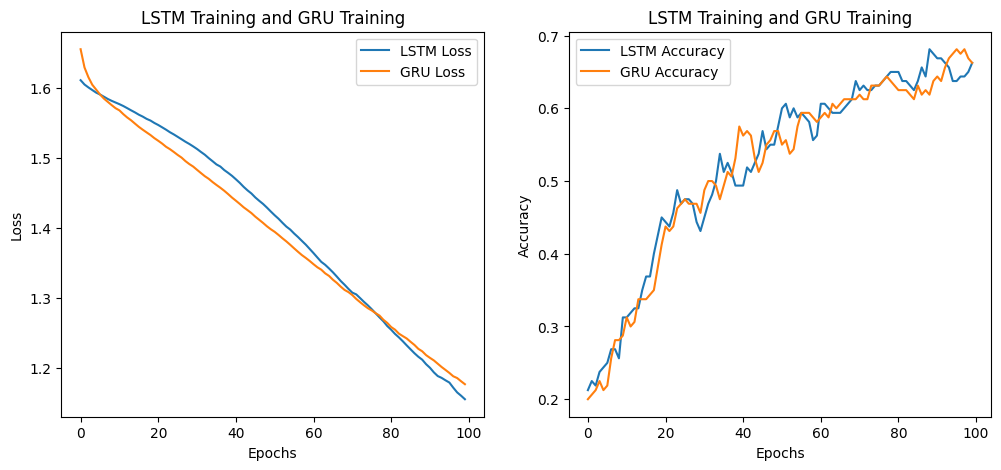

In [22]:
plt.figure(figsize=(12, 5))

# Plot LSTM Loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.plot(history_gru.history['loss'], label='GRU Loss')
plt.title('LSTM Training and GRU Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot GRU Loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='LSTM Accuracy')
plt.plot(history_gru.history['accuracy'], label='GRU Accuracy')
plt.title('LSTM Training and GRU Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

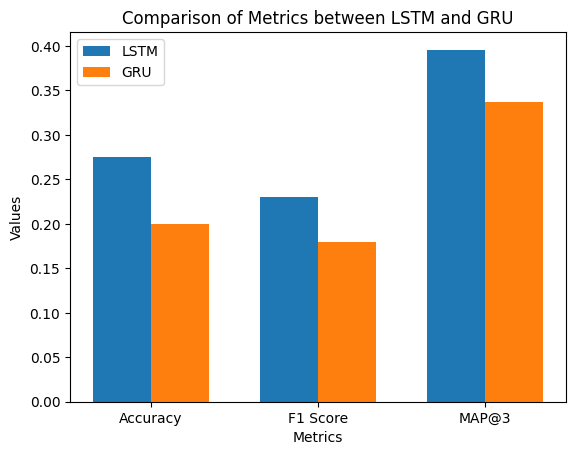

In [23]:
# Plotting the bar chart
labels = ['Accuracy', 'F1 Score', 'MAP@3']
lstm_metrics = [accuracy_lstm, f1_lstm, map_at_3_lstm]
gru_metrics = [accuracy_gru, f1_gru, map_at_3_gru]

bar_width = 0.35
index = np.arange(len(labels))

plt.bar(index, lstm_metrics, bar_width, label='LSTM')
plt.bar(index + bar_width, gru_metrics, bar_width, label='GRU')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Metrics between LSTM and GRU')
plt.xticks(index + bar_width / 2, labels)
plt.legend()
plt.show()

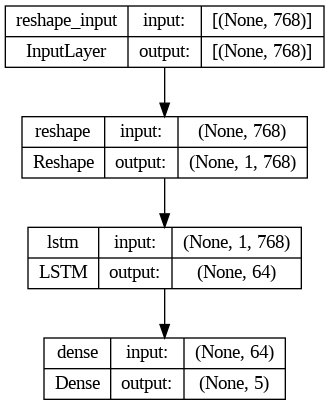

In [24]:
tf.keras.utils.plot_model(model_lstm, show_shapes=True)

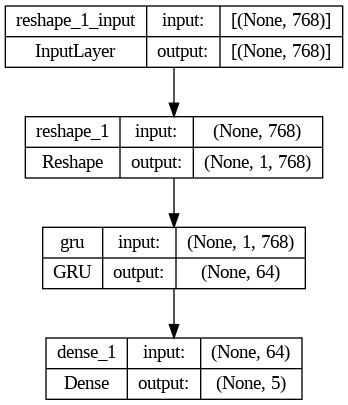

In [25]:
tf.keras.utils.plot_model(model_gru, show_shapes=True)

### Save model

In [26]:
best_model_lstm = model_lstm  # Thay thế bằng biến mô hình tốt nhất của bạn

# Lưu mô hình vào một tệp
joblib.dump(best_model_lstm, 'model_lstm.pkl')

best_model_gru = model_gru  # Thay thế bằng biến mô hình tốt nhất của bạn

# Lưu mô hình vào một tệp
joblib.dump(best_model_gru, 'model_gru.pkl')

['model_gru.pkl']

In [27]:
def classify_text(input_text):
    # Tokenize the input text
    input_tokens = tokenizer(input_text, truncation=True, padding='max_length', max_length=512, return_tensors="pt")

    # Get BERT embeddings
    with torch.no_grad():
        outputs = model(**input_tokens)
        embeddings = outputs.last_hidden_state

    # Convert embeddings to NumPy array and then to PyTorch tensor
    embeddings = embeddings.numpy()
    X = embeddings.mean(axis=1)

    # Make a prediction using the LSTM model
    y_pred = model_lstm.predict(X)

    # Return the predicted probabilities
    return y_pred[0]

In [28]:
#Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed "missing baryonic mass" discrepancy in galaxy clusters?

#input_text = input("Nhập văn bản cần phân loại: ")
#predicted_probabilities = classify_text(input_text)
#print("Predicted probabilities:", predicted_probabilities)
#print("Predicted answer:", 'ABCDE'[predicted_probabilities.argmax()])

Nhập văn bản cần phân loại: Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed "missing baryonic mass" discrepancy in galaxy clusters?
1/1 [==============================] - 0s 26ms/step
Predicted probabilities: [0.2461555  0.24499601 0.24454086 0.14293662 0.12137105]
Predicted answer: A


# Data Test

###Load data test

In [29]:
test_df = pd.read_csv('/content/test.csv', index_col='id')
test_df.head()

,prompt,A,B,C,D,E
id,,,,,,
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...
1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...
3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...
4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...


In [30]:
test_df.shape

(200, 6)

### Tokenizer data and BERT embeddings

In [31]:
test_inputs = test_df.apply(lambda row: " ".join([str(row["prompt"]), str(row["A"]), str(row["B"]), str(row["C"]), str(row["D"]), str(row["E"])]), axis=1).values.tolist()
test_encodings = tokenizer(test_inputs, truncation=True, padding='max_length', max_length=512, return_tensors="pt")

# Obtain BERT embeddings for the test set
with torch.no_grad():
    test_outputs = model(**test_encodings)
    test_embeddings = test_outputs.last_hidden_state

### Dự đoán câu trả lời đúng

In [32]:
# Convert embeddings to NumPy array and then to PyTorch tensor
test_embeddings = test_embeddings.numpy()
X_test = test_embeddings.mean(axis=1)

# Predict using the trained LSTM model
y_test_pred_probs = model_lstm.predict(X_test)
y_test_pred_classes = y_test_pred_probs.argmax(axis=-1)

# Map class indices back to original labels
predicted_labels = encoder.inverse_transform(y_test_pred_classes)

# Print or further process the predicted labels
print(predicted_labels)

7/7 [==============================] - 0s 3ms/step
['C' 'A' 'B' 'E' 'D' 'E' 'E' 'D' 'C' 'E' 'D' 'A' 'C' 'D' 'B' 'C' 'C' 'C'
 'C' 'E' 'D' 'D' 'C' 'C' 'E' 'E' 'A' 'B' 'E' 'C' 'C' 'E' 'E' 'B' 'C' 'C'
 'E' 'A' 'E' 'E' 'E' 'B' 'B' 'C' 'A' 'C' 'B' 'C' 'D' 'B' 'B' 'E' 'C' 'C'
 'B' 'B' 'C' 'C' 'C' 'A' 'C' 'B' 'C' 'B' 'A' 'A' 'E' 'C' 'C' 'B' 'C' 'D'
 'C' 'B' 'C' 'B' 'A' 'B' 'B' 'E' 'C' 'A' 'C' 'E' 'E' 'D' 'E' 'B' 'E' 'D'
 'E' 'C' 'B' 'C' 'C' 'C' 'B' 'D' 'D' 'B' 'C' 'B' 'C' 'B' 'C' 'D' 'C' 'E'
 'D' 'C' 'C' 'B' 'A' 'B' 'C' 'C' 'D' 'C' 'D' 'E' 'A' 'C' 'B' 'E' 'A' 'C'
 'B' 'C' 'C' 'E' 'C' 'C' 'B' 'B' 'C' 'B' 'B' 'B' 'A' 'A' 'B' 'B' 'B' 'B'
 'C' 'B' 'B' 'C' 'C' 'B' 'B' 'D' 'A' 'C' 'B' 'C' 'C' 'C' 'B' 'C' 'A' 'E'
 'D' 'B' 'C' 'C' 'E' 'D' 'E' 'C' 'B' 'E' 'B' 'A' 'D' 'C' 'D' 'B' 'C' 'C'
 'B' 'A' 'A' 'C' 'A' 'B' 'B' 'A' 'E' 'D' 'E' 'C' 'C' 'C' 'D' 'D' 'B' 'B'
 'C' 'C']


In [33]:
y_pred = model_lstm.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Additional prints for evaluation
for i in range(5):  # Assuming there are 5 classes (ABCDE)
    answer_probs = y_pred[i]
    top_k_idxs = answer_probs.argsort()[-3:][::-1]
    print("Answer probs:", answer_probs)
    print("Top 3:", ['ABCDE'[k] for k in top_k_idxs])
    print('Predicted answer:', 'ABCDE'[answer_probs.argmax()])
    print()

7/7 [==============================] - 0s 3ms/step
Answer probs: [0.1751074  0.14028086 0.29477286 0.21228464 0.17755416]
Top 3: ['C', 'D', 'E']
Predicted answer: C

Answer probs: [0.30865708 0.09037815 0.17510828 0.18262462 0.24323191]
Top 3: ['A', 'E', 'D']
Predicted answer: A

Answer probs: [0.25144097 0.32628933 0.13393362 0.07374439 0.2145917 ]
Top 3: ['B', 'A', 'E']
Predicted answer: B

Answer probs: [0.21370769 0.11933701 0.19852294 0.08826183 0.38017058]
Top 3: ['E', 'A', 'C']
Predicted answer: E

Answer probs: [0.08237289 0.08710645 0.13868614 0.63297594 0.05885861]
Top 3: ['D', 'C', 'B']
Predicted answer: D

